### Data Preparation for Zero-Shot Text Classification
loads and cleans data from a CSV file into a pandas DataFrame, removing specific columns for a streamlined dataset. define candidate labels for a zero-shot text classification task aimed at identifying various types of offensive content.

In [2]:
import pandas as pd
from transformers import pipeline

# Load data
train = pd.read_csv("train.csv")

# Remove the 'severe_toxic' column from the DataFrame
train = train.drop(columns=['severe_toxic'])
train = train.drop(columns=['id'])

# Define candidate labels
candidate_labels = ['toxic', 'obscene', 'threat', 'insult', 'identity_hate']


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Analyzing Message Categorization in Data
analyzes the distribution of message categories in a DataFrame by calculating the percentage of messages labeled under specific categories like 'toxic' and 'obscene'. It also determines the percentage of messages that do not fit any of the specified categories, assuming these to be 'other'

In [3]:
# Total data processed
total_data = len(train)
print(f"Total data processed: {total_data}")

# Calculate and print the percentage of messages labeled for each category
for label in candidate_labels:
    label_count = train[label].sum()
    percentage = (label_count / total_data) * 100
    print(f"Percentage of '{label}' messages: {percentage:.2f}%")

# Calculate the percentage of messages that are not labeled as any of the specified categories
# This assumes that a message not having any of the labels 1 means it is "other"
non_other_labels = train[candidate_labels].max(axis=1)
percentage_other = ((non_other_labels == 0).sum() / total_data) * 100
print(f"Percentage of 'other' messages: {percentage_other:.2f}%")


Total data processed: 159571
Percentage of 'toxic' messages: 9.58%
Percentage of 'obscene' messages: 5.29%
Percentage of 'threat' messages: 0.30%
Percentage of 'insult' messages: 4.94%
Percentage of 'identity_hate' messages: 0.88%
Percentage of 'other' messages: 89.83%


### Sample and Classify Labeled Messages Using Zero-Shot Models
filter a DataFrame to include only rows where any specified label such as 'toxic' or 'obscene' is present, and randomly selects 200 of these rows. initialize zero-shot classification pipelines for various models, setting up for text classification without needing specific training on the dataset's labels.

In [4]:
# Filter the DataFrame to include only rows where any of the specified labels is 1
labeled_rows = train[train[candidate_labels].any(axis=1)]

# Randomly select 200 rows from the filtered DataFrame
sampled_rows = labeled_rows.sample(n=200, random_state=1)

# Models to use
models = [
    "roberta-large-mnli",                  # General-purpose RoBERTa model for natural language inference, based on the Multi-Genre NLI Corpus
    "facebook/bart-large-mnli",            # BART model fine-tuned for multi-genre natural language inference, based on the MultiNLI (MNLI) dataset
    "unitary/toxic-bert",                  # BERT model specifically trained to identify toxic comments, based on the Jigsaw Toxic Comment Classification Challenge Dataset.
    "s-nlp/roberta_toxicity_classifier",   # RoBERTa model fine-tuned for toxicity classification, based on the Jigsaw Toxic Comment Classification Challenge Dataset.
    "martin-ha/toxic-comment-model",       # fine-tuned version of the DistilBERT model to classify toxic comments, based on the Civil Comments platform dataset.
    "JungleLee/bert-toxic-comment-classification", # BERT model fine-tuned for classifying toxic comments, based on the Civil Comments platform dataset.
]

# Initialize zero-shot classification pipelines for each model
classifiers = {model: pipeline("zero-shot-classification", model=model) for model in models}


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceCl

### Accuracy Assessment of Zero-Shot Classification Models
Calculate the accuracy of various zero-shot classification models on a sampled dataset. Define functions to compute row-wise accuracy and apply model predictions, then execute these tasks. The script outputs the accuracy for each label and overall row accuracy, providing insights into model performance across multiple categories.

In [5]:
from sklearn.metrics import accuracy_score
from concurrent.futures import ThreadPoolExecutor

# Define a function to calculate row-wise accuracy for a given model
def calculate_row_wise_accuracy(data, model_name):
    model_name_key = model_name.replace('/', '_')

    def is_row_correct(row):
        predictions = row[f'predictions_{model_name_key}']
        return all(predictions[label] == row[label] for label in candidate_labels)

    correct_predictions = data.apply(is_row_correct, axis=1)
    return correct_predictions.mean()

# Function to apply predictions and calculate accuracies
def apply_predictions_and_calculate_accuracy(model_name, data):
    print(f"Processing model: {model_name}")
    classifier = classifiers[model_name]
    model_name_key = model_name.replace('/', '_')

    def get_predictions(text):
        result = classifier(text, candidate_labels, multi_label=True)
        predictions = {label: 1 if score >= 0.5 else 0 for label, score in zip(result['labels'], result['scores'])}
        return predictions

    data[f'predictions_{model_name_key}'] = data['comment_text'].apply(get_predictions)

    accuracies = {}
    for label in candidate_labels:
        data[label + f'_{model_name_key}'] = data[f'predictions_{model_name_key}'].apply(lambda x: x.get(label, 0))
        accuracies[label] = accuracy_score(data[label], data[label + f'_{model_name_key}'])

    row_accuracy = calculate_row_wise_accuracy(data, model_name)
    return accuracies, row_accuracy

# Execute model predictions and calculate accuracies in parallel

with ThreadPoolExecutor(max_workers=16) as executor:
    futures = {executor.submit(apply_predictions_and_calculate_accuracy, model, sampled_rows): model for model in models}
    for future in futures:
        model_name = futures[future]
        accuracies, row_accuracy = future.result()
        print(f"Accuracies by label for {model_name}: {accuracies}")
        print(f"Row-wise Accuracy for {model_name}: {row_accuracy}")



Processing model: roberta-large-mnli
Processing model: facebook/bart-large-mnli
Processing model: unitary/toxic-bert
Processing model: s-nlp/roberta_toxicity_classifier
Processing model: martin-ha/toxic-comment-model
Processing model: JungleLee/bert-toxic-comment-classification
Accuracies by label for roberta-large-mnli: {'toxic': 0.85, 'obscene': 0.615, 'threat': 0.22, 'insult': 0.59, 'identity_hate': 0.745}
Row-wise Accuracy for roberta-large-mnli: 0.025
Accuracies by label for facebook/bart-large-mnli: {'toxic': 0.805, 'obscene': 0.565, 'threat': 0.155, 'insult': 0.575, 'identity_hate': 0.705}
Row-wise Accuracy for facebook/bart-large-mnli: 0.02
Accuracies by label for unitary/toxic-bert: {'toxic': 0.055, 'obscene': 0.44, 'threat': 0.96, 'insult': 0.47, 'identity_hate': 0.885}
Row-wise Accuracy for unitary/toxic-bert: 0.0
Accuracies by label for s-nlp/roberta_toxicity_classifier: {'toxic': 0.815, 'obscene': 0.665, 'threat': 0.24, 'insult': 0.645, 'identity_hate': 0.28}
Row-wise Accu

In [6]:
print(sampled_rows.head(5))
csv_file_path = "path_to_save_sampled_rows.csv"
sampled_rows.to_csv(csv_file_path, index=False)  # Set index=False to not save row indices

                                             comment_text  toxic  obscene  \
114065  I Should be Surprised\n\nBut I'm not. Its exac...      1        0   
32121   No Irishlass I think that you are the one that...      1        0   
92024   I fucked your dad last night you fucking whore...      1        1   
37408   "\n\n RE: NAIR!!! \n\nSorry Karl, I wasn't abl...      1        1   
81449   you are deluded and i advise that you seek som...      1        0   

        threat  insult  identity_hate  \
114065       0       0              0   
32121        0       0              0   
92024        0       1              0   
37408        1       1              1   
81449        0       0              0   

                predictions_martin-ha_toxic-comment-model  \
114065  {'insult': 0, 'identity_hate': 0, 'threat': 0,...   
32121   {'obscene': 0, 'toxic': 0, 'insult': 0, 'threa...   
92024   {'obscene': 1, 'toxic': 1, 'insult': 1, 'threa...   
37408   {'toxic': 0, 'insult': 0, 'identity_ha

### Identifying Optimal Models for Each Label
Analyze the accuracies of various zero-shot classification models for different toxic content labels and identifies the model with the highest accuracy for each category. It iteratively compares the accuracy of models across labels such as 'toxic', 'obscene', 'threat', 'insult', and 'identity hate', storing the best-performing model for each. 

In [7]:
model_accuracies = {}

# Accuracies provided for each model and label
for future in futures:
    model_name = futures[future]
    accuracies, row_accuracy = future.result()
    print(f"{model_name}: {accuracies}")
    model_accuracies[model_name] = accuracies


# Find the highest accuracy per label
best_model_per_label = {}
for label in ['toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    best_model = None
    max_accuracy = 0
    for model, accuracies in model_accuracies.items():
        if accuracies[label] > max_accuracy:
            max_accuracy = accuracies[label]
            best_model = model
    best_model_per_label[label] = (best_model, max_accuracy)

# Output best models and their accuracies per label
for label, (model, accuracy) in best_model_per_label.items():
    print(f"Best model for {label}: {model} with accuracy {accuracy:.2f}")



roberta-large-mnli: {'toxic': 0.85, 'obscene': 0.615, 'threat': 0.22, 'insult': 0.59, 'identity_hate': 0.745}
facebook/bart-large-mnli: {'toxic': 0.805, 'obscene': 0.565, 'threat': 0.155, 'insult': 0.575, 'identity_hate': 0.705}
unitary/toxic-bert: {'toxic': 0.055, 'obscene': 0.44, 'threat': 0.96, 'insult': 0.47, 'identity_hate': 0.885}
s-nlp/roberta_toxicity_classifier: {'toxic': 0.815, 'obscene': 0.665, 'threat': 0.24, 'insult': 0.645, 'identity_hate': 0.28}
martin-ha/toxic-comment-model: {'toxic': 0.65, 'obscene': 0.725, 'threat': 0.365, 'insult': 0.685, 'identity_hate': 0.44}
JungleLee/bert-toxic-comment-classification: {'toxic': 0.945, 'obscene': 0.555, 'threat': 0.05, 'insult': 0.54, 'identity_hate': 0.125}
Best model for toxic: JungleLee/bert-toxic-comment-classification with accuracy 0.94
Best model for obscene: martin-ha/toxic-comment-model with accuracy 0.72
Best model for threat: unitary/toxic-bert with accuracy 0.96
Best model for insult: martin-ha/toxic-comment-model with 

In [19]:
print(best_model_per_label)

{'toxic': 'JungleLee/bert-toxic-comment-classification', 'obscene': 'martin-ha/toxic-comment-model', 'threat': 'unitary/toxic-bert', 'insult': 's-nlp/roberta_toxicity_classifier', 'identity_hate': 'unitary/toxic-bert'}


In [16]:
# Display the best accuracy for each label
for label, (accuracy) in best_model_per_label.items():
    print(f"Best accuracy for {label}: {accuracy})")

Best accuracy for toxic: JungleLee/bert-toxic-comment-classification)
Best accuracy for obscene: martin-ha/toxic-comment-model)
Best accuracy for threat: unitary/toxic-bert)
Best accuracy for insult: s-nlp/roberta_toxicity_classifier)
Best accuracy for identity_hate: unitary/toxic-bert)


### Model Performance Analysis Across Toxicity Categories
create bar charts to compare the performance of different models across five toxicity categories: Toxic, Obscene, Threat, Insult, and Identity Hate.


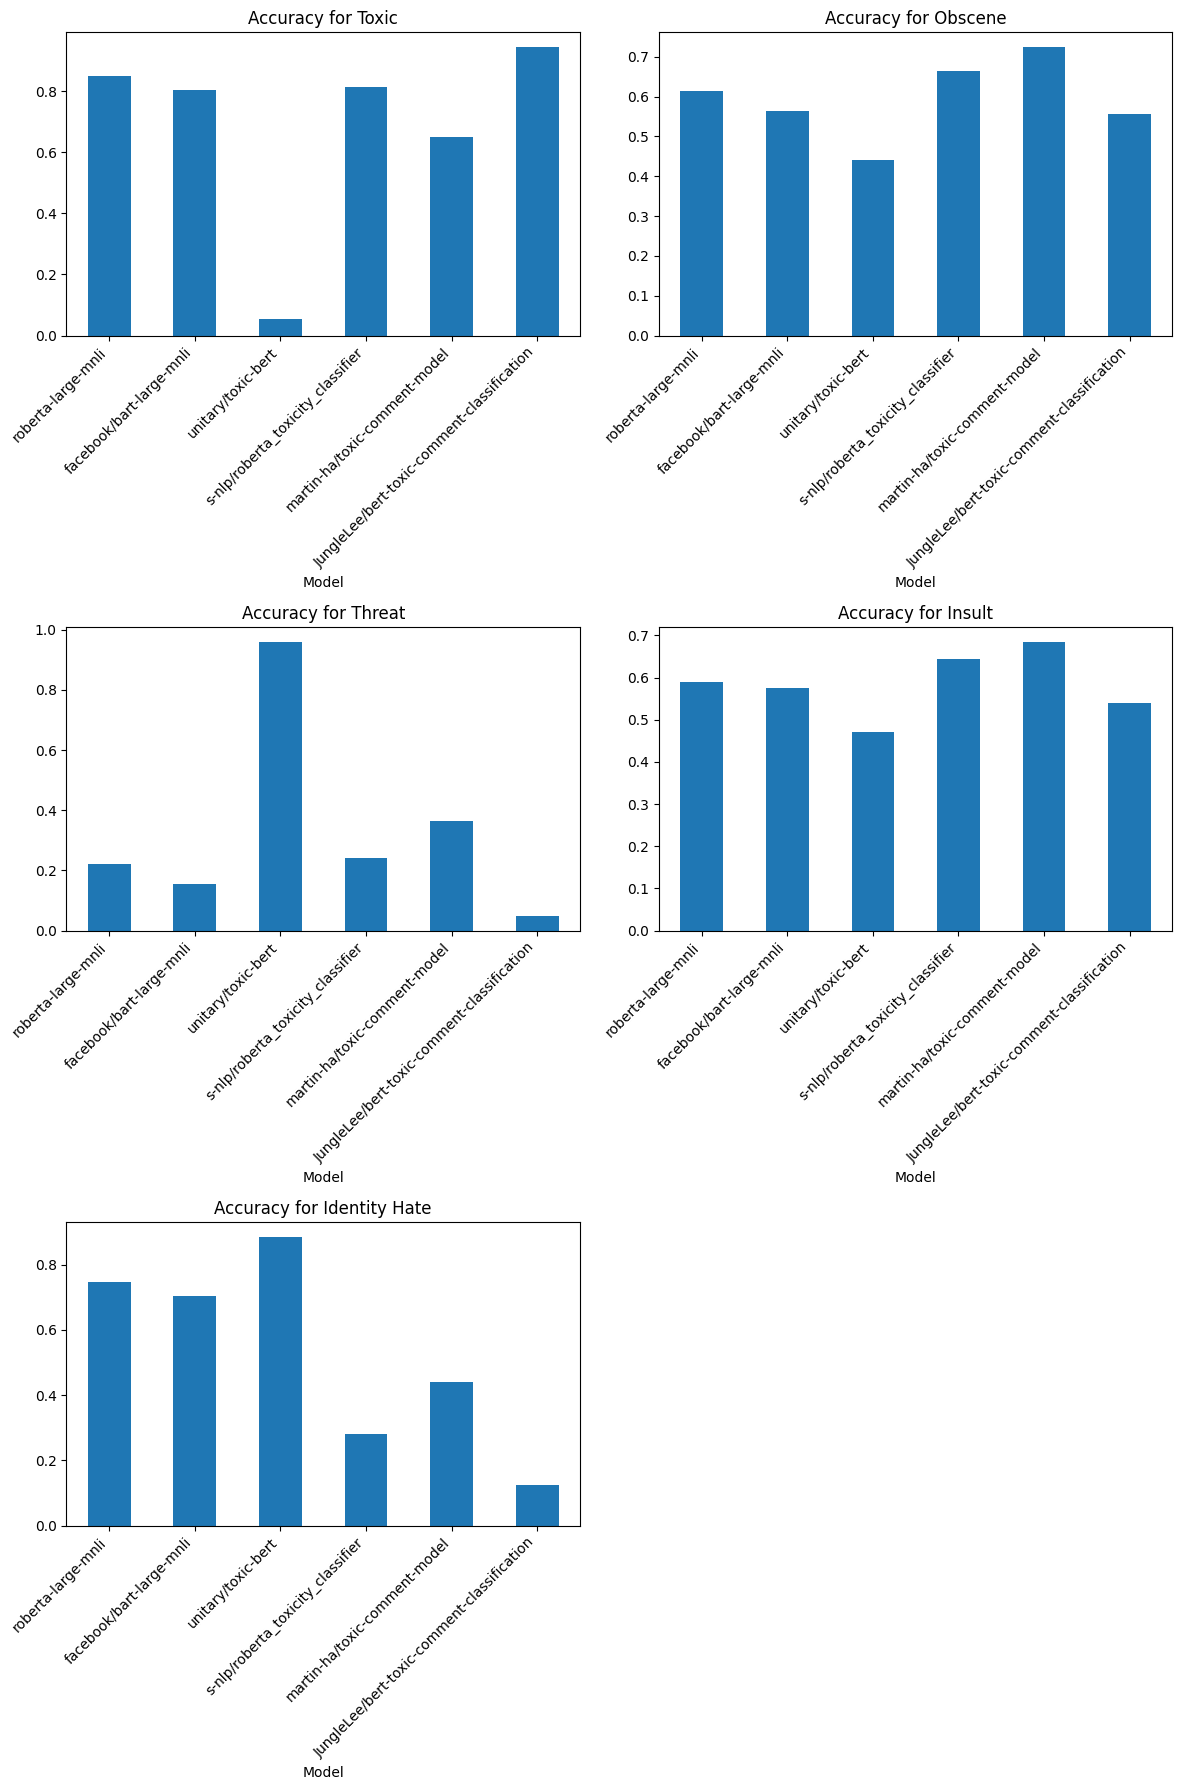

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Creating a DataFrame from the given accuracies and models
data = {
    'Model': [
        "roberta-large-mnli", "facebook/bart-large-mnli", "unitary/toxic-bert",
        "s-nlp/roberta_toxicity_classifier", "martin-ha/toxic-comment-model",
        "JungleLee/bert-toxic-comment-classification"
    ],
    'Dataset': [
        "Multi-Genre NLI", "Multi-Genre NLI", "Jigsaw Toxic Comment",
        "Jigsaw Toxic Comment", "Civil Comments", "Civil Comments"
    ],
    'Toxic': [0.85, 0.805, 0.055, 0.815, 0.65, 0.945],
    'Obscene': [0.615, 0.565, 0.44, 0.665, 0.725, 0.555],
    'Threat': [0.22, 0.155, 0.96, 0.24, 0.365, 0.05],
    'Insult': [0.59, 0.575, 0.47, 0.645, 0.685, 0.54],
    'Identity Hate': [0.745, 0.705, 0.885, 0.28, 0.44, 0.125]
}

df = pd.DataFrame(data)

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # Adjust the subplot layout
axes = axes.ravel()  # Flatten axes array
categories = ['Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']

for i, category in enumerate(categories):
    ax = df.plot.bar(x='Model', y=category, ax=axes[i], legend=None, title=f'Accuracy for {category}')
    ax.set_xticklabels(df['Model'], rotation=45, horizontalalignment='right')

axes[-1].axis('off')  # Hide the last subplot if it's unused

fig.tight_layout()
plt.show()


### Comparative Analysis of Model Accuracies Across Toxicity Categories
create a line chart representing the accuracy of various models across different toxicity categories such as Toxic, Obscene, Threat, Insult, and Identity Hate.

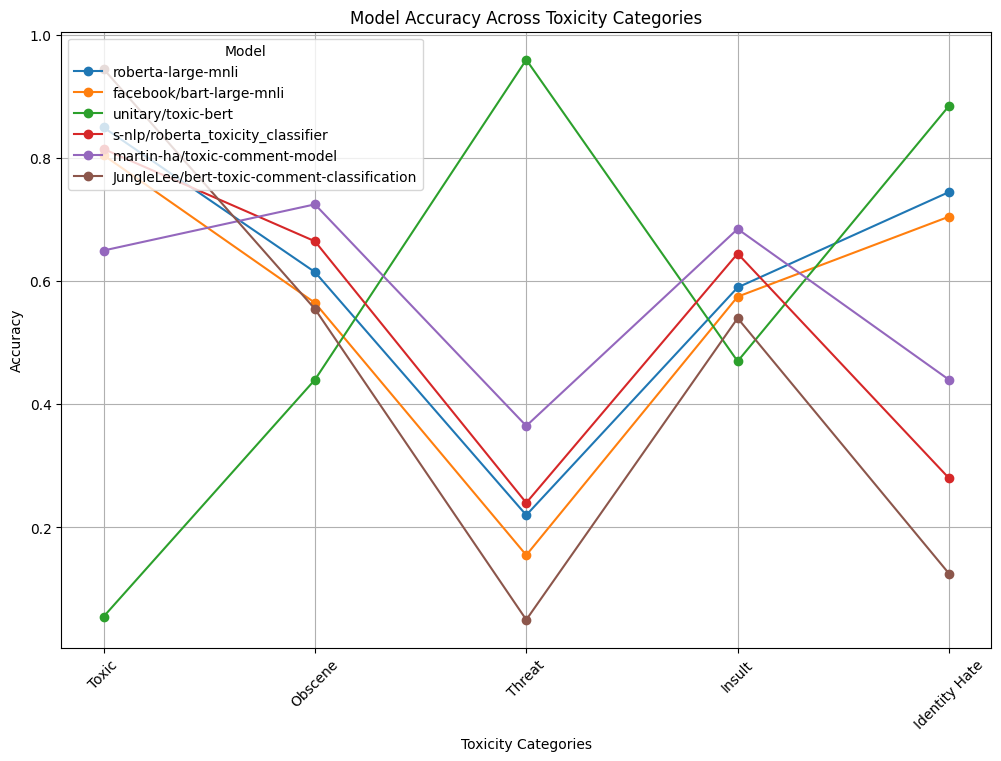

In [33]:
# Creating a DataFrame from the given accuracies and models
df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

# Plotting
plt.figure(figsize=(12, 8))

for model in df.index:
    plt.plot(df.columns, df.loc[model], marker='o', label=model)

plt.title('Model Accuracy Across Toxicity Categories')
plt.xlabel('Toxicity Categories')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title="Model", loc='upper left')
plt.grid(True)

plt.show()


### Calculating and Analyzing the Best Prediction Accuracy for Text Classification
Define two functions to determine the best predictions from multiple models for text classification tasks and calculates the row-wise accuracy.

In [17]:
# Function to get the best predictions for each label
def get_best_predictions(data):
    best_predictions = {}
    for label in candidate_labels:
        model_name = best_model_per_label[label]
        model_key = model_name.replace('/', '_')
        best_predictions[label] = data[f'predictions_{model_key}'].apply(lambda x: x.get(label, 0))
    return best_predictions

# Function to calculate row-wise accuracy using the best predictions
def calculate_row_wise_accuracy(data):
    # Add best predictions to DataFrame
    best_predictions = get_best_predictions(data)
    for label, predictions in best_predictions.items():
        data[f'best_{label}'] = predictions

    # Determine if all best predictions match the actual labels
    def is_row_correct(row):
        return all(row[f'best_{label}'] == row[label] for label in candidate_labels)

    correct_predictions = data.apply(is_row_correct, axis=1)
    return correct_predictions.mean()

# Run model predictions, calculate best predictions, and row-wise accuracy

final_row_accuracy = calculate_row_wise_accuracy(sampled_rows)
print(f"Final Row-Wise Accuracy: {final_row_accuracy}")


Final Row-Wise Accuracy: 0.385
